In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
from skportfolio.datasets import load_tech_stock_prices
prices = load_tech_stock_prices()

In [4]:
from pypfopt.plotting import plot_efficient_frontier

In [5]:
from pypfopt.expected_returns import mean_historical_return

In [6]:
import numpy as np

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context("notebook")
sns.set(font="Arial")
plt.style.use('ggplot')
sns.set_style('ticks')
%config InlineBackend.figure_format="svg"
mpl.rcParams["figure.autolayout"] = True

mpl.rcParams['font.family'] = 'Arial'

# Plotting Omega ratio figures

Definition of Omega ratio:

\begin{equation}
\Omega(r) = \dfrac{\int_{\tau}^\infty (1-F(r)) dr}{\int_{-\infty}^{\tau} F(r) dr}.
\end{equation}

Operative definition:

\begin{equation}
\Omega(r_P) = \dfrac{\mathbf{w}^T \boldsymbol \mu - \tau}{\left<  (\tau - \mathbf{w}^T \mathbf{R})^+ \right >} + 1
\end{equation}

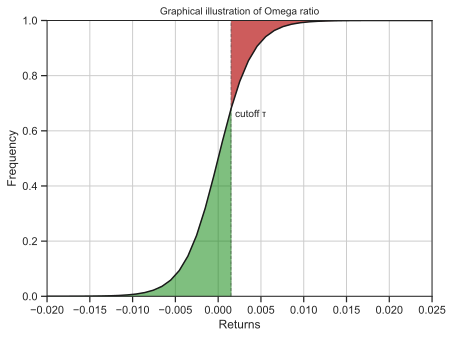

In [9]:
from scipy.special import expit
x = np.linspace(-0.05,0.05,100)
tau=0.0015
y=expit(500*x)
plt.plot(x,y,color='k')
plt.xlim([-0.02,0.025])
plt.axvline(x=tau, linestyle='-.', color='k', linewidth=0.5)
plt.annotate(' cutoff τ', xy=(tau*1.1,0.65))
plt.ylim([0,1])
plt.title('Graphical illustration of Omega ratio', fontsize=10)
plt.fill_between(x[0:52], y1=0, y2=expit(500*x[0:52]), color='green', alpha=0.5)
plt.fill_between(x[51:], y1=expit(500*x[51:]), y2=1, color='indianred')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid('both')
#plt.savefig('docs/imgs/omega_ratio.svg',bbox_inches='tight')

# Plotting Omega ratio frontier

\begin{split}
\begin{equation*}
\begin{aligned}
\textrm{Omega numerator} =& \mathbf{w}^T \boldsymbol \mu - \tau \\
\textrm{Omega denominator} =& \sum_{t=1}^T \max \left( \tau - \mathbf{w}^T R_t, 0 \right )
\end{aligned}
\end{equation*}
\end{split}

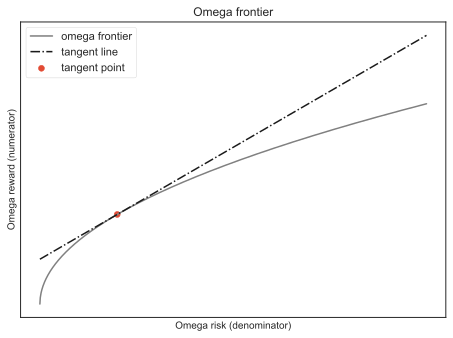

In [10]:
x=np.linspace(0,5,1000)
fig,ax = plt.subplots()
ax.plot(x,np.sqrt(x), color='gray', label='omega frontier')
ax.plot(x,(1+x)*0.5,color='k',linestyle='-.',label='tangent line')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False
)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False
) # labels along th
ax.set_xlabel('Omega risk (denominator)', fontsize=10)
ax.set_ylabel('Omega reward (numerator)', fontsize=10)
ax.set_title('Omega frontier', fontsize=12)
plt.scatter(x=[1], y=[1], label='tangent point')
plt.legend()
#plt.savefig('docs/imgs/omega_frontier.svg', bbox_inches='tight')

In [20]:
from skportfolio import OmegaEfficientReturn, MaxOmegaRatio, OmegaEfficientRisk, MinimumOmegaRisk
from skportfolio.frontier._omega import omega_risk, omega_reward
from pypfopt.expected_returns import mean_historical_return,returns_from_prices

In [13]:
mu = mean_historical_return(prices,returns_data=False, compounding=False, log_returns=False)
returns = returns_from_prices(prices)

In [17]:
from skportfolio import MinimumOmegaRisk
omega_risk(
    MinimumOmegaRisk(
        minimum_acceptable_return=tau
    ).fit(prices)
    .weights_,
    returns,
    tau
)

0.004611281181350325

In [21]:
from pypfopt.plotting import plot_efficient_frontier
from skportfolio import MinimumOmegaRisk
import pandas as pd

tau = 0.0

wmin = MinimumOmegaRisk(minimum_acceptable_return=tau).fit(prices).weights_
min_omega_risk = omega_risk(
    wmin,
    returns,
    tau
)

max_omega_risk = omega_risk(pd.Series(index=returns.columns,data=(mu==mu.max()).astype(float)),returns,tau)
wmax = MaxOmegaRatio(minimum_acceptable_return=tau).fit(prices).weights_

num, den = [], []
x = np.linspace(0, np.max(mu)*2, 200)

for r in x:
    w = OmegaEfficientReturn(
        minimum_acceptable_return=tau
    ).set_target_return(r).fit(prices).weights_
    
    num.append(omega_reward(w, mu, tau))
    den.append(omega_risk(w, returns, tau))

/Users/carlo/workspace/scikit-portfolio/skportfolio/frontier/_efficientfrontier.py:107: UserWarning: target_return must be lower than the maximum possible return
  warnings.warn(str(ex))


In [22]:
from skportfolio.metrics import omega_ratio, portfolio_return

In [24]:
from skportfolio import EquallyWeighted

(0.0041501530632152926, 0.0123487941785489)

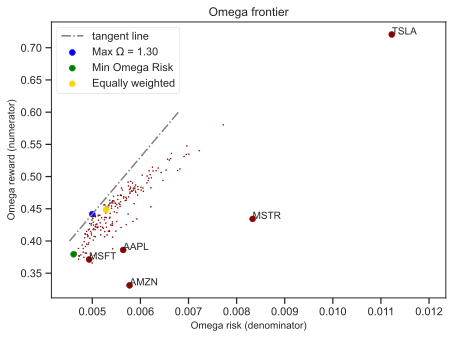

In [26]:
fig, ax = plt.subplots()
ax.plot(den, num, color='k')
#ax.fill_between(x=den, y1=0, y2=num, color='indianred')
ax.set_xlabel('Omega risk (denominator)', fontsize=10)
ax.set_ylabel('Omega reward (numerator)', fontsize=10)
ax.set_title('Omega frontier', fontsize=12)

slope = (omega_reward(wmax,mu,tau)/omega_risk(wmax,returns,tau))
xstar = np.linspace(0.4,0.6)
ax.plot(xstar/slope,xstar,label='tangent line',color='grey',linestyle='-.')
ax.scatter(x=omega_risk(wmax,returns,tau), y=omega_reward(wmax,mu,tau), color='blue',label=f'Max $\Omega$ = {omega_ratio(prices.dot(wmax).pct_change().dropna()):.2f}')
ax.scatter(x=omega_risk(wmin,returns,tau), y=omega_reward(wmin,mu,tau), color='green',label='Min Omega Risk')

for w in np.random.rand(200,returns.shape[1]):
    w = pd.Series(index=returns.columns,data=w/w.sum())
    ax.scatter(x=omega_risk(w,returns,tau), y=omega_reward(w,mu,tau),s=1, color='darkred')

# equally weighted
ax.scatter(
    x=omega_risk(EquallyWeighted().fit(prices).weights_,returns,tau), 
    y=omega_reward(EquallyWeighted().fit(prices).weights_,mu,tau),
    color='gold',
    label='Equally weighted'
)
    
for i,w in enumerate(np.eye(returns.shape[1])):
    w = pd.Series(index=returns.columns,data=w/w.sum())
    ax.scatter(x=omega_risk(w,returns,tau), y=omega_reward(w,mu,tau), color='darkred')
    ax.annotate(text=returns.columns[i], xy=(omega_risk(w,returns,tau), omega_reward(w,mu,tau)))
ax.legend()
ax.set_xlim([min_omega_risk*0.9, max_omega_risk*1.1])

#plt.savefig('docs/imgs/omega_frontier_real.svg',bbox_inches='tight')

In [27]:
from skportfolio import PerturbedReturns, MaxOmegaRatio

ImportError: cannot import name 'MichaudResampledFrontier' from 'skportfolio' (/Users/carlo/workspace/scikit-portfolio/skportfolio/__init__.py)

In [ ]:
estimator = MaxOmegaRatio()

In [ ]:
estimator.risk_estimator

In [ ]:
ensemble = MichaudResampledFrontier(
    ptf_estimator=MaxOmegaRatio(),
    n_iter=256,
    n_jobs=-1
).fit(prices)

In [ ]:
from skportfolio._efficientfrontier import MinimumOmegaRisk

In [ ]:
from skportfolio import *
import matplotlib.pyplot as plt
plt.figure()
prices.dot(ensemble.weights_.values.T).plot(label='Ensemble Omega')
prices.dot(MaxOmegaRatio().fit(prices).weights_.values.T).plot(label='Max Omega')
prices.dot(MaxSharpe().fit(prices).weights_.values.T).plot(label='Sharpe')
plt.legend()

############
plt.figure()
prices.dot(ensemble.weights_.values.T).pct_change().hist(bins=200,label='Ensemble Omega',alpha=0.5)
prices.dot(MaxOmegaRatio().fit(prices).weights_.values.T).pct_change().hist(bins=200,label='Max Omega',alpha=0.5)
prices.dot(MaxSharpe().fit(prices).weights_.values.T).pct_change().hist(bins=200,label='Sharpe',alpha=0.5)
plt.legend()

In [ ]:
prices.dot(MinimumOmegaRisk().fit(prices).weights_.values.T).plot(label='Min Omega')
prices.dot(MinimumVolatility().fit(prices).weights_.values.T).plot(label='Min Vol')
#prices.dot(MinimumSemiVolatility().fit(prices).weights_.values.T).plot(label='Min SemiVol')
#prices.dot(MinimumCDar().fit(prices).weights_.values.T).plot(label='Min CDar')
plt.legend()

In [ ]:
MaxOmegaRatio(rets_estimator=PerturbedReturns()).fit(prices).weights_

In [ ]:
ensemble.ptf_estimator._optimizer(prices)

In [ ]:

p=PerturbedReturns()